In [1]:
# Autoreload extension for Jupyter notebooks
%load_ext autoreload
%autoreload 2

# Manual reload
from importlib import reload

# Magic commands for inline plotting and high-res figures
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Standard library imports
import os
import sys
import pickle
from pprint import pprint

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rsmf.abstract_formatter
import seaborn as sns
from jupyterthemes import jtplot

# Custom modules (if needed)
# module_path = os.path.join(os.path.expanduser('~'), 'CustomModules')
# sys.path.append(module_path)
# from telegram_notify import notify
# from plotting_tools import error_band_plot, get_ax_data_range

# Add the parent directory to sys.path (if needed)
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent.parent))

# Pandas configurations
pd.set_option('display.max_rows', 1000)
idx = pd.IndexSlice

# Figure formatting
import rsmf
FIG_FORMATTER: rsmf.abstract_formatter.AbstractFormatter = rsmf.setup(
    r"\documentclass[a4paper,twocolumn,10pt,unpublished]{quantumarticle}"
)
COLORS = plt.get_cmap('tab10')

plt.rcParams.update({
    "axes.prop_cycle": plt.cycler("color", plt.cm.tab10.colors),
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "figure.constrained_layout.use": True,
    "figure.constrained_layout.h_pad": 0.02,
    "figure.constrained_layout.w_pad": 0.02,
    "figure.constrained_layout.hspace": 0.01,
    "figure.constrained_layout.wspace": 0.01,
    "legend.framealpha": 0.5,
})

# For in-line display of rsmf figures
import matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
matplotlib.use('module://matplotlib_inline.backend_inline')

# Utility functions
def write_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pickle(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

from simulations.analysis.plotting_helpers import error_band_plot, load_data, take_best_by_from_df_ps_dict

## Generate an example circuit

In [21]:
H = np.loadtxt("../data/hgp_check_matrices/(3,4)_n225_k9_d6/example.txt")
H = H.astype("uint8")

In [27]:
from build_random_hgp_circuits import compute_hgp_code_parameters

code, code_prms = compute_hgp_code_parameters(H, H)

print(code_prms)

(225, 9, 6)


In [40]:
from build_random_hgp_circuits import build_hgp_circuit_from_code

dv, dc = 3, 4
n, k, d = code_prms
T = d
p = 1e-3

# Create circuit
circuit = build_hgp_circuit_from_code(code, p, T)

In [42]:
# Save circuit
circuit_dir = "../data/hgp_prebuilt/circuits"
circuit_subdir = os.path.join(circuit_dir, f"({dv},{dc})_n{n}_k{k}_d{d}_T{T}_p{p}")
os.makedirs(circuit_subdir, exist_ok=True)
circuit.to_file(os.path.join(circuit_subdir, f"example.stim"))

## pfail vs pabort

In [2]:
filter = {"n": 225, "k": 9, "d": 6}
df_ps_dict = load_data("hgp", filter=filter)

In [4]:
df_ps_dict.keys()

dict_keys(['cluster_llr_norm_2', 'cluster_size_norm_gap_inf', 'cluster_llr_norm_gap_0.5', 'cluster_size_norm_inf', 'cluster_llr_norm_gap_1', 'cluster_llr_norm_0.5', 'cluster_size_norm_1', 'detector_density', 'cluster_size_norm_gap_1', 'cluster_llr_norm_1', 'cluster_llr_norm_inf', 'cluster_size_norm_0.5', 'cluster_llr_norm_gap_inf', 'cluster_size_norm_2', 'cluster_size_norm_gap_0.5', 'cluster_llr_norm_gap_2', 'pred_llr', 'cluster_size_norm_gap_2'])

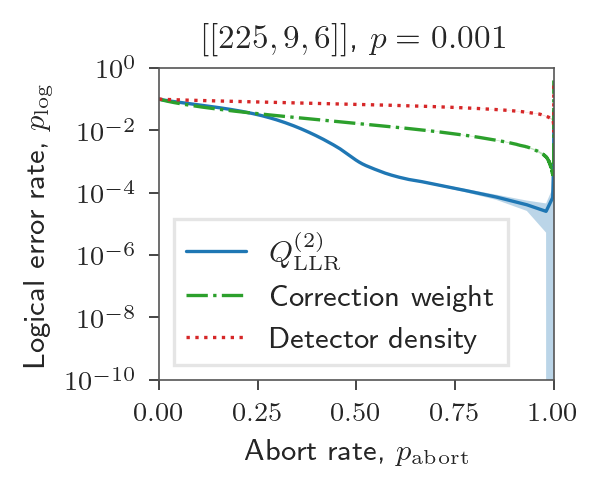

In [21]:
fig = FIG_FORMATTER.figure(wide=True, width_ratio=0.35, aspect_ratio=0.8)
ax = fig.add_subplot()

prms = (225, 9, 6, 6, 1e-3)
n, k, d, T, p = prms

keys = ["cluster_llr_norm_2", "pred_llr", "detector_density"]
labels = [r"$Q_\mathrm{LLR}^{(2)}$", r"Correction weight", r"Detector density"]
colors = [COLORS(0), COLORS(2), COLORS(3)]
linestyles = ["-", "-.", ":"]

i = 0
data_plots = {}
for by in keys:
    p_abort_col = "p_abort"
    p_fail_col = "p_fail"
    delta_p_fail_col = "delta_p_fail"

    df_ps = df_ps_dict[by].loc[prms].reset_index()

    df_ps = df_ps.sort_values(by=p_abort_col)
    p_abort = df_ps[p_abort_col].values
    p_fail = df_ps[p_fail_col].values
    delta_p_fail = df_ps[delta_p_fail_col].values
    data_plots[by] = (p_abort, p_fail, delta_p_fail)

    error_band_plot(
        p_abort,
        p_fail,
        delta_p_fail,
        color=colors[i],
        linestyle=linestyles[i],
        label=labels[i],
        ax=ax,
    )
    i += 1

# ax.set_xscale("log")
ax.set_xlim(0, 1)
ax.set_yscale("log")
ax.legend()
ax.set_ylim(1e-10, 1)
ax.set_yticks(10.0 ** np.arange(-10, 1, 2))
ax.set_title(rf"$[[{n}, {k}, {d}]]$, $p={p}$", fontsize=10)

ax.set_xlabel(r"Abort rate, $p_\mathrm{abort}$")
ax.set_ylabel(r"Logical error rate, $p_\mathrm{log}$")

fig.savefig("overleaf_figs/hgp_code_metric_comparison_plog_vs_pabort.pdf")

In [23]:
prms = (225, 9, 6, 6, 1e-3)
n, k, d, T, p = prms

# Create ordered list of keys
ordered_keys = df_ps_dict.keys()

i = 0
data_plots = {}
for by in ordered_keys:
    try:
        df_ps = df_ps_dict[by].loc[prms].reset_index()
    except KeyError:
        continue

    p_abort_col = "p_abort"
    p_fail_col = "p_fail"
    delta_p_fail_col = "delta_p_fail"

    df_ps = df_ps.sort_values(by=p_abort_col)
    p_abort = df_ps[p_abort_col].values
    p_fail = df_ps[p_fail_col].values
    delta_p_fail = df_ps[delta_p_fail_col].values
    data_plots[by] = (p_abort, p_fail, delta_p_fail)

0: cluster_size_norm_2 (1.76e-04 ± 4.73e-06)
1: cluster_size_norm_inf (1.81e-04 ± 4.79e-06)
2: cluster_llr_norm_2 (1.86e-04 ± 4.87e-06)
3: cluster_llr_norm_inf (1.88e-04 ± 4.89e-06)
4: cluster_llr_norm_gap_inf (2.18e-04 ± 5.26e-06)
5: cluster_llr_norm_gap_2 (2.39e-04 ± 5.50e-06)
6: cluster_size_norm_gap_inf (2.67e-04 ± 5.83e-06)
7: cluster_size_norm_1 (2.97e-04 ± 6.13e-06)
8: cluster_size_norm_gap_2 (2.97e-04 ± 6.12e-06)
9: cluster_size_norm_gap_1 (3.02e-04 ± 6.21e-06)
10: cluster_llr_norm_gap_1 (3.29e-04 ± 6.44e-06)
11: cluster_llr_norm_1 (3.29e-04 ± 6.44e-06)
12: cluster_size_norm_gap_0.5 (2.03e-03 ± 1.60e-05)
13: pred_llr (2.80e-03 ± 1.88e-05)
14: cluster_llr_norm_gap_0.5 (4.57e-03 ± 2.38e-05)
15: cluster_llr_norm_0.5 (6.65e-03 ± 2.86e-05)
16: cluster_size_norm_0.5 (6.94e-03 ± 2.92e-05)
17: detector_density (1.15e-02 ± 3.64e-05)


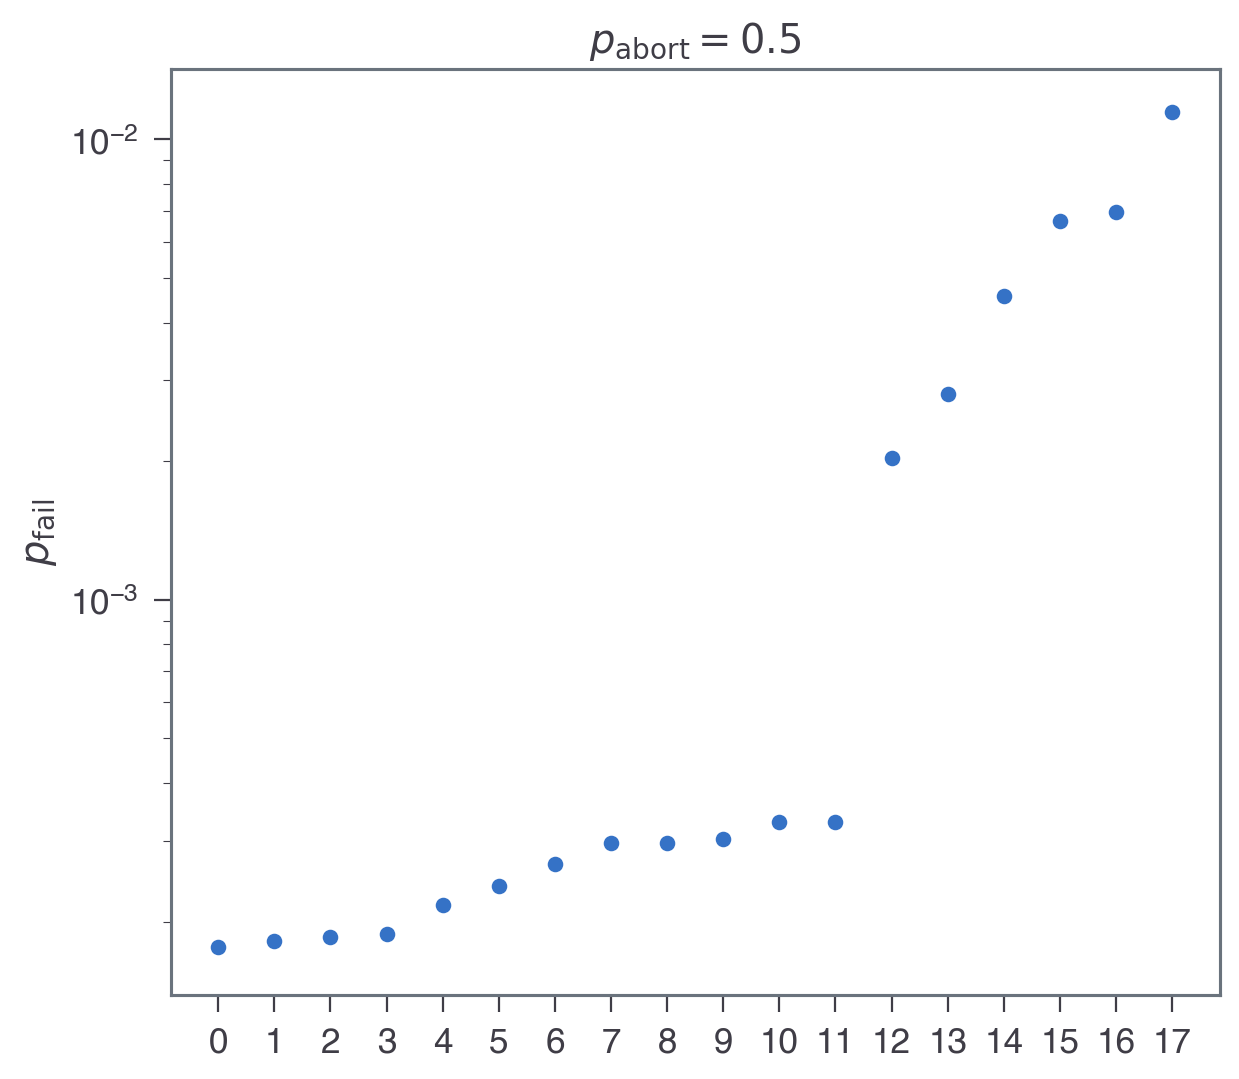

In [ ]:
target = 0.5
bys, y_vals, y_errs = [], [], []

for by, (p_abort, p_fail, delta_p_fail) in data_plots.items():
    idx = np.where(p_abort <= target)[0]
    if len(idx):
        sel = idx[-1]
    else:
        sel = 0
    bys.append(by)
    y_vals.append(p_fail[sel])
    y_errs.append(delta_p_fail[sel])

sort_inds = np.argsort(y_vals)
by_sorted = [bys[i] for i in sort_inds]
y_vals_sorted = [y_vals[i] for i in sort_inds]
y_errs_sorted = [y_errs[i] for i in sort_inds]

for i, by in enumerate(by_sorted):
    print(f"{i}: {by} ({y_vals_sorted[i]:.2e} ± {y_errs_sorted[i]:.2e})")

x_pos = np.arange(len(bys))

plt.errorbar(
    x_pos,
    y_vals_sorted,
    yerr=y_errs_sorted,
    fmt="o",
    capsize=5,
    lw=1.5,
    markeredgecolor="k",
)
plt.title(rf"$p_\mathrm{{abort}} = {target}$")
plt.xticks(x_pos, x_pos)
plt.ylabel(r"$p_{\mathrm{fail}}$")
plt.yscale("log")
plt.tight_layout()
plt.show()